### Кластеризация всех семейств  
1. Сохранение в датафрейм кластеризации всего банка и сравнение кластеризованных данных разными алгоритмами.  
2. Распределение количества выделенных кластеров на смоделированных данных (**старый** банк) сравнивается с распределением количества выделенных кластеров в экспериментальном банке.
3. Для рассмотренных алгоритмов кластеризации на **старом** модельном банке строится корреляционный плот: количество выделяемых кластеров по семействам в зависимости от среднего количества высот (иеальной кластеризации) в множестве, для которого выделяется такое количество кластеров.  (То есть, например, в 6, 10, 90 семействе всего 7, 4, 5 различных высот, но во всех трёх семействах алгоритмом выделено 5 кластеров. Координата точки корреляционного плота будет (5, 5.3) )

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import datetime
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import spearmanr

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
import hdbscan
le_h = LabelEncoder()

In [3]:
from custom_functions import matrix_of_distance
from custom_functions import CoefPFI
from custom_functions import PamirAlgorithm
from custom_functions import *

In [6]:
# ГРАФИКА
large = 22; med = 18; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
sns.set(style="whitegrid")

In [7]:
def noise_cluster(labels):
    """
    Убирает шумовые точки, обозначая их отдельными кластерами.
    
    Входные значения:
    labels - метки кластеров.
    
    Выходные значения:
    labels - метки кластеров безшума -1.
    """
    if -1 not in labels:
        return labels
    
    coef = len(set(labels))-1
    for i in range(len(labels)):  
        if labels[i] == -1:
            coef+=1
            labels[i] = labels[i]+coef
    return labels

In [8]:
def ClusteringAGLCLUST(eps, X):
    clustering = AgglomerativeClustering(n_clusters=None, affinity = 'precomputed', distance_threshold = eps, linkage = 'average').fit(X)
    labels = clustering.labels_    
    return labels

In [9]:
def ClusteringDBSCAN(eps, X):
    db = DBSCAN(eps=eps, min_samples = 1).fit(X)
    labels = db.labels_
    return noise_cluster(labels)

In [10]:
def ClusteringMeanShift(eps, X):
    clustering = MeanShift(bandwidth=eps).fit(X)
    labels = clustering.labels_
    return labels

In [11]:
def ClusteringOptics(eps, X):
    clustering = OPTICS(min_samples = 2).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [12]:
def ClusteringHdbscan(eps, X):
    clustering = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
                            gen_min_span_tree=False, leaf_size=1, min_cluster_size=2, min_samples=None, p=None).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [13]:
def ClusteringAffinity(eps, X):
    clustering = AffinityPropagation(damping = 0.9, random_state=5).fit(X)
    labels = clustering.labels_
    return labels

In [26]:
def clustering(data, name, j_name = ' j'):
    """
    Кластеризует все семейства всеми алгоритмами.
    
    Входные параметры:
    data - датафрейм семейств,
    name - имя колонки с номером семейства,
    j_name - имя колонки с номером частицы.
    
    Возвращаемые значения:
    Датафрейм с кластеризацией всеми алгоритмами.
    """
    
    nums =list(set(data[name].values))
    clustered_df = []
    
    print('start: ', datetime.datetime.now())
    
    for i in nums:
        if i%100 == 0:
            print(i, datetime.datetime.now())
        
        # Выделяем семмейство
        df = data[data[name]==i].copy()
        
        # Строим матрицу расстояний со вторым коэффициентом расстояния
        X = matrix_of_distance(df['X(J)'].values, df['Y(J)'].values, df['E(J)'].values, 2)
        
        # aglomerative
        eps = np.percentile(df['ER'], 50)
        df['cluster_agl'] = ClusteringAGLCLUST(eps, X)
        
        # dbscan
        eps = np.percentile(df['ER'], 95)
        df['cluster_db'] = ClusteringDBSCAN(eps, X)
        
        #meanshift
        eps = np.percentile(df['ER'], 95)
        df['cluster_ms'] = ClusteringMeanShift(eps, X)
        
        # optics
        df['cluster_op'] = ClusteringOptics(eps, X)
        
        # hdbscan
        df['cluster_hd'] = ClusteringHdbscan(eps, X)
        
        # affinity
        df['cluster_af'] = ClusteringAffinity(eps, X)
        
        
        df['cluster_pam'] = PamirAlgorithm(df, 
                                           eps = 48, 
                                           num_name = name,
                                           j_name = j_name)
        
        clustered_df.append(df)
        
    
    clustered_df = pd.concat(clustered_df)

    return clustered_df

In [16]:
# Новый модельный банк.
# AllMc0 = pd.read_csv('datachanged/AllMc0CNewBank', sep = '\t')
# Старый модельный банк.
olddata = pd.read_csv('datachanged/AllMc0COld', sep = '\t')

In [17]:
# Экспериментальные данные.
AllExp = pd.read_csv('datachanged/AllExpC')
AllExp = AllExp.drop(['Unnamed: 0'], axis = 1)

In [2]:
# %%time
# clustered_df = clustering(AllMc0, 'num')

In [18]:
# clustered_df.head()

In [19]:
%%time
clustered_df_old = clustering(olddata, ' num_of_family')

start:  2022-03-17 09:04:06.634051
100 2022-03-17 09:04:21.158052
200 2022-03-17 09:04:41.247327
300 2022-03-17 09:04:52.494260
400 2022-03-17 09:05:03.468921
500 2022-03-17 09:05:14.374715
600 2022-03-17 09:05:25.383274
700 2022-03-17 09:05:36.816703
800 2022-03-17 09:05:51.245164
900 2022-03-17 09:06:05.626703
1000 2022-03-17 09:06:18.088408
1100 2022-03-17 09:06:32.922204
1200 2022-03-17 09:06:46.312444
Wall time: 2min 52s


In [20]:
clustered_df_old.head()

,num_of_family,j,X(J),Y(J),E(J),H(J),E0,A0,log_E0,R,ER,sum_energy,cluster_agl,cluster_db,cluster_ms,cluster_op,cluster_hd,cluster_af,j_new,cluster_pam
0,1,1,-3.013189,-7.227429,4.611031,1255.250,3366.712,1,3.527206,7.830392,36.106180,370.199507,7,0,8,7,2,0,0,3
1,1,2,-1.310529,-2.563248,12.047700,1545.054,3366.712,1,3.527206,2.878841,34.683415,370.199507,8,1,6,8,3,0,1,3
2,1,3,-2.178048,-2.144561,5.401844,3044.520,3366.712,1,3.527206,3.056638,16.511481,370.199507,6,2,7,9,1,0,2,3
3,1,4,-0.965465,-0.082880,5.325506,4715.523,3366.712,1,3.527206,0.969016,5.160501,370.199507,1,3,0,2,1,0,3,2
4,1,5,-1.621645,0.079540,15.935060,3044.520,3366.712,1,3.527206,1.623595,25.872076,370.199507,3,4,4,10,1,0,4,2


In [27]:
%%time
clustered_df_exp = clustering(AllExp, ' num_of_fam', 'j')

start:  2022-03-17 09:11:21.865800
200 2022-03-17 09:11:43.860984
300 2022-03-17 09:11:53.158121
400 2022-03-17 09:12:06.883786
500 2022-03-17 09:12:24.414640
600 2022-03-17 09:12:37.119062
700 2022-03-17 09:12:48.742974
800 2022-03-17 09:13:00.891457
900 2022-03-17 09:13:15.060565
Wall time: 1min 56s


In [28]:
clustered_df_exp.head()

,num_of_fam,j,X(J),Y(J),E(J),R,cnt,ER,sum_energy,lg_r,lg_e_r,cluster_agl,cluster_db,cluster_ms,cluster_op,cluster_hd,cluster_af,j_new,cluster_pam
0,1,1,0.2513,-1.0370,20.896,1.067015,13,22.296342,145.8,0.028170,1.348234,0,0,0,0,2,0,0,0
1,1,2,0.6003,-0.5482,13.749,0.812947,13,11.177213,145.8,-0.089938,1.048334,0,0,0,4,1,0,1,0
2,1,3,0.3081,-1.0631,11.535,1.106846,13,12.767464,145.8,0.044087,1.106105,0,0,0,1,3,0,2,0
3,1,4,0.6618,-0.5704,6.129,0.873691,13,5.354850,145.8,-0.058642,0.728747,0,0,0,2,1,0,3,0
4,1,5,0.5843,-0.5611,8.619,0.810086,13,6.982133,145.8,-0.091469,0.843988,0,0,0,3,1,0,4,0


In [27]:
# Сохранение обработанных файлов в папку datachanged
# clustered_df.to_csv('clusterdata/clusteredDF', sep = '\t', index = False)

In [30]:
# Сохранение обработанных файлов в папку datachanged
# clustered_df_old.to_csv('clusterdata/clusteredDFold', sep = '\t', index = False)

In [31]:
# Сохранение обработанных файлов в папку datachanged
# clustered_df_exp.to_csv('clusterdata/clusteredDFexp', sep = '\t', index = False)

### Распределение по количеству выделенных кластеров в модели и в эксперименте.

In [10]:
#clustered_df = pd.read_csv('clusterdata/clusteredDF', sep = '\t')
# кластеризация экспериментальных данных
clustered_df_exp = pd.read_csv('clusterdata/clusteredDFexp', sep = '\t')
# кластеризация старой модели
clustered_df_old = pd.read_csv('clusterdata/clusteredDFold', sep = '\t')

In [11]:
def unique_clust(data, name, clust):
    nums = list(set(data[name]))
    Unique_H = []
    
    for num in nums:
        value = len(data[data[name]==num][clust].unique())
        Unique_H.append(value)
        
    return Unique_H

In [12]:
# Распределение по количеству выделенных кластеров в семействах

#uniq_h_new = unique_clust(clustered_df, 'num', 'cluster_agl')
uniq_h_old = unique_clust(clustered_df_old, ' num_of_family', 'cluster_agl')
uniq_h_exp = unique_clust(clustered_df_exp, ' num_of_fam', 'cluster_agl')

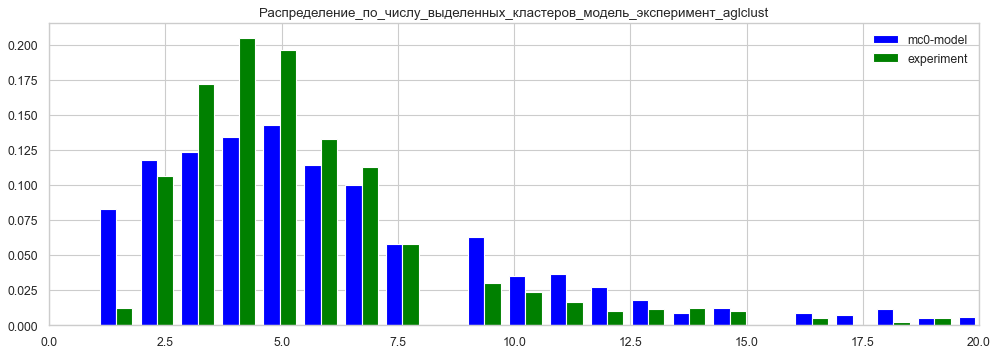

In [34]:
# Распределение по высотам
tit = 'Распределение_по_числу_выделенных_кластеров_модель_эксперимент_aglclust'
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title(tit)

plt.hist([uniq_h_old, uniq_h_exp], bins = 50, density = True, color  = ['blue', 'green'], label = ['mc0-model', 'experiment'])
#plt.savefig(f'images/distributions/{tit}.png')
plt.xlim([0,20])
plt.legend()
plt.savefig(f'images/clustering_h/mc0_exp_agl.png')
plt.show()

# PSI 
https://wiki.loginom.ru/articles/stability-index.html   
https://habr.com/ru/company/plarium/blog/515178/  

cross-entr = $\sum_{i=1}^N (y_{ti} - y_{bi})(ln(y_{ti}) - ln(y_{bi})) = \sum_{i=1}^N (y_{ti} - y_{bi})ln\big(\frac{y_{ti}}{y_{bi}}\big) $

# Кросс-энтропия
https://habr.com/ru/post/484756/     
https://dementiy.github.io/notes/cross-entropy/  
https://zen.yandex.ru/media/id/5fd12882382a85570c79c48c/crossentropy-v-mashinnom-obuchenii-prostymi-slovami-60dd996a53a79f06f9669c83  

In [35]:
def psi(expected_array, actual_array, buckets=10):
    ''' Эта метрика позволяет измерить то, 
    насколько переменная изменилась в распределении между двумя выборками.
    Чем больше, тем сильнее изменение.
    '''
    def scale_range (array, min_arr, max_arr):
        array += -(np.min(array))
        array /= np.max(array) / (max_arr - min_arr)
        array += min_arr
        return array
    
    expected_array = np.array(expected_array)
    actual_array = np.array(actual_array)
    
    
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
    
    expected = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
    expected = np.where(expected == 0, 0.00001, expected)
    actual = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
    actual = np.where(actual == 0, 0.00001, actual)
    
    psi_value = np.sum((expected - actual)*np.log(expected/actual))
    return psi_value 

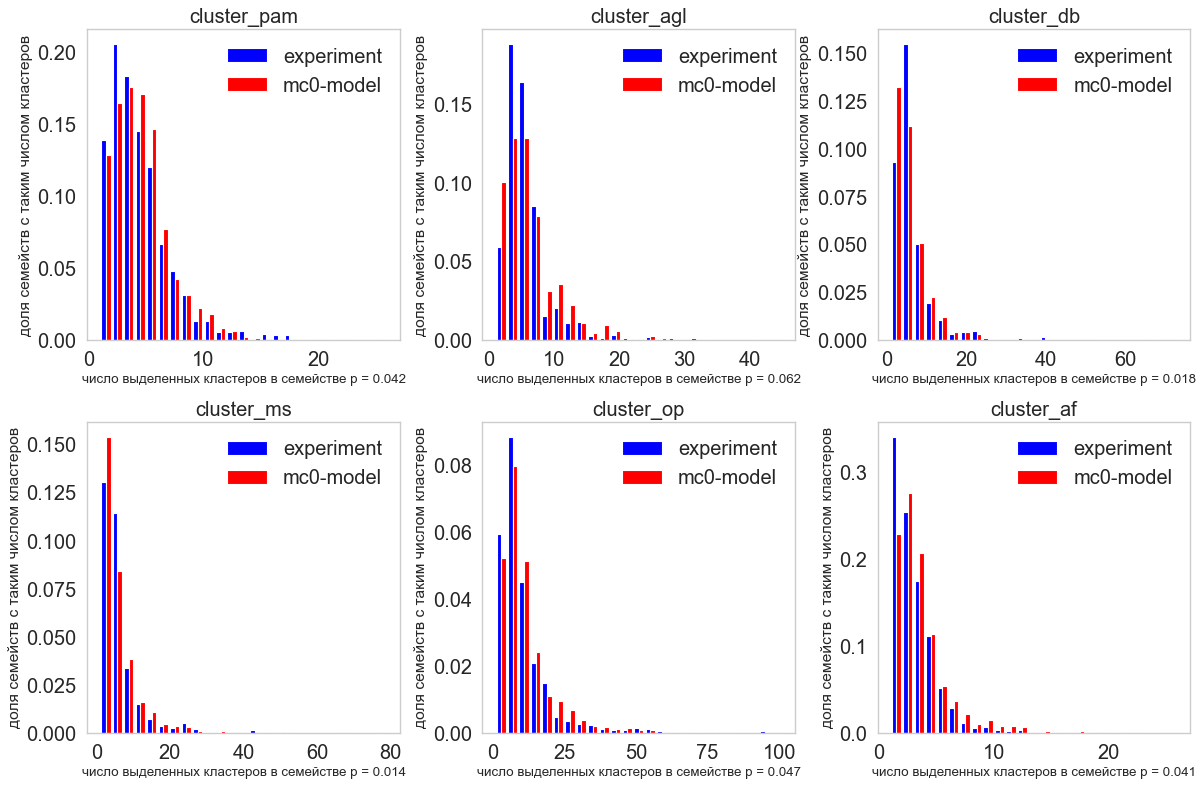

In [91]:
algorithm = ['cluster_pam', 'cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op',  'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.rcParams.update(params)

for i in range(6): 
    
    uniq_h_old = unique_clust(clustered_df_old, ' num_of_family', algorithm[i])
    uniq_h_exp = unique_clust(clustered_df_exp, ' num_of_fam', algorithm[i])
    # stat, p = np.around(mannwhitneyu(uniq_h_old, uniq_h_exp), 3)
    p = round(psi(uniq_h_old, uniq_h_exp),3)
    
    plt.subplot(2, 3, i+1)
    plt.rcParams.update(params)
    plt.title(algorithm[i])
    
    plt.hist([uniq_h_exp, uniq_h_old], bins = 25, density = True, label=['experiment', 'mc0-model'], 
             color = ["blue" , "red"])
#     plt.hist(uniq_h_old, bins=50, density=True, alpha=0.8, color='blue', label='mc0-model')
#     plt.hist(uniq_h_exp, bins=50, density=True, alpha=0.8, color='green', label='experiment')
    
    plt.grid()
    plt.legend()
    plt.xlabel(f'число выделенных кластеров в семействе p = {p}', size=12)
    plt.ylabel('доля семейств с таким числом кластеров', size=14)
    
plt.tight_layout()
plt.savefig(f'images/clustering_h/mc0_exp.png')

### Корреляционный плот - число уникальных высот высот - число кластеров выделенных алгоритмов кластеров (в среднем) для такого числа высот

In [14]:
def return_number_h_cluster(data, name, clust):
    """
    Возвращает датафрейм: число кластеров - число высот.
    """
    nums = list(set(data[name]))

    number_dom_h = []
    number_clusters = []
    
    mean_sigma = 0
    
    for num in nums:

        # Выделяем одно семейство
        one = data[data[name]==num].copy()
        
        clusters = []
        dom_h_one = []
                    
        # число кластеров  
        number_clusters.append(len(one[clust].unique()))
        
        # число высот в семействе         
        number_h_one = len(one['H(J)'].unique())
        number_dom_h.append(number_h_one)
            
    return pd.DataFrame({'num': nums, 'number_h':number_dom_h, 'number_clusters': number_clusters})

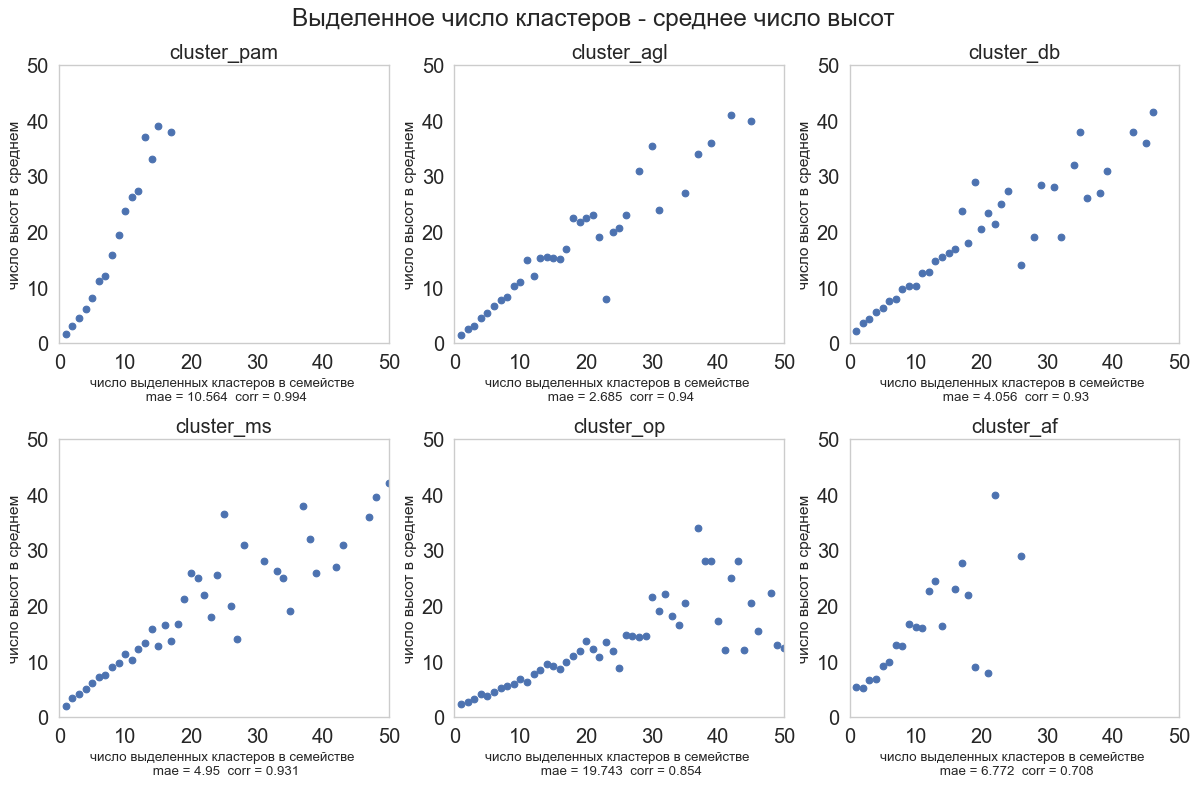

In [18]:
algorithm = ['cluster_pam', 'cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.suptitle('Выделенное число кластеров - среднее число высот')
plt.rcParams.update(params)

for i in range(6): 
    
    plotdf = return_number_h_cluster(clustered_df_old, ' num_of_family', algorithm[i])  
    plotdf = plotdf.groupby('number_clusters').mean().reset_index()
    
    m = round(mae(plotdf['number_clusters'], plotdf['number_h']), 3)
    corr = round(spearmanr(plotdf['number_clusters'].values, plotdf['number_h'].values)[0], 3)
    
    plt.subplot(2, 3, i+1)
    plt.title(algorithm[i])
    
    plt.plot(plotdf['number_clusters'], plotdf['number_h'],  'o')
    
    plt.rcParams.update(params)
    plt.xlabel(f'число выделенных кластеров в семействе \n mae = {m}  corr = {corr}', size=12)
    plt.ylabel('число высот в среднем', size=14)
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    #plt.legend()
    plt.grid()
    
plt.tight_layout()
plt.savefig(f'images/clustering_h/mean_h_clust.png')

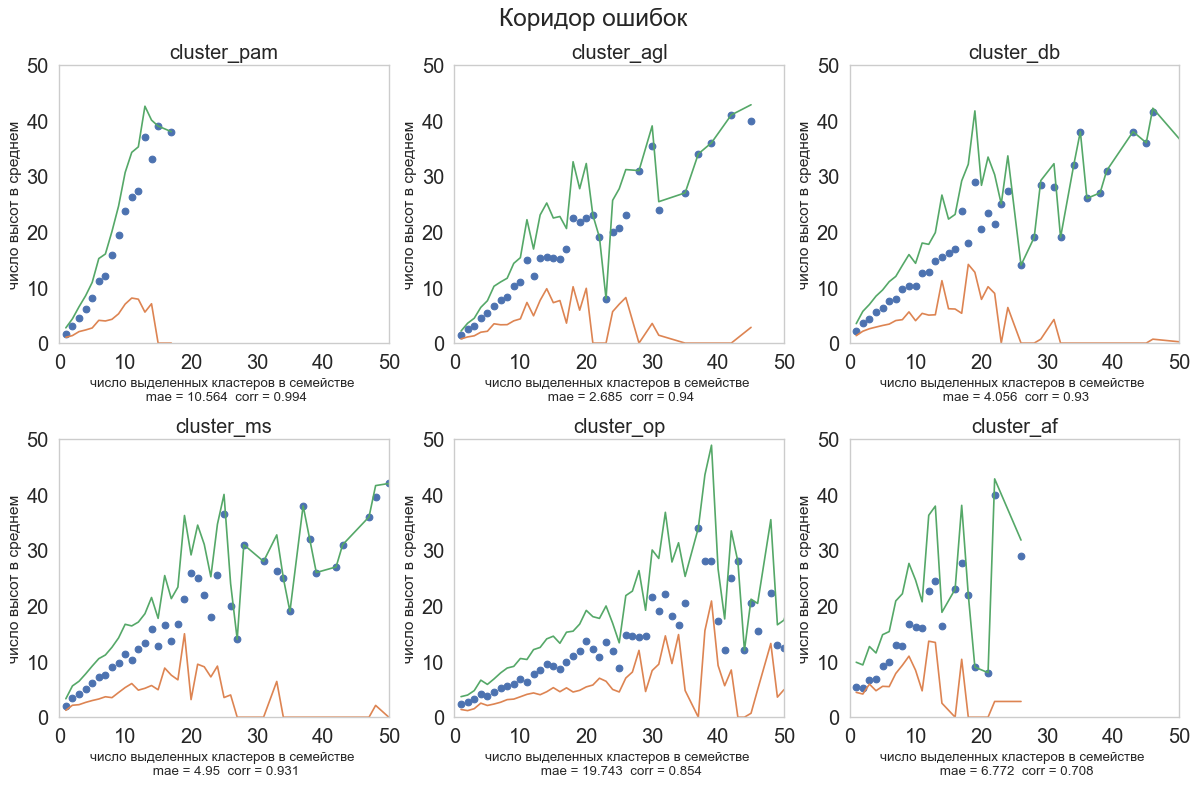

In [76]:
algorithm = ['cluster_pam', 'cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.suptitle('Коридор ошибок')
plt.rcParams.update(params)

for i in range(6): 
    
    plotdf = return_number_h_cluster(clustered_df_old, ' num_of_family', algorithm[i])  
    plotdf = plotdf.groupby('number_clusters').agg({'number_h': ['mean', 'std']}).fillna(0).reset_index()
    
    number_clusters = plotdf['number_clusters']
    number_h = plotdf['number_h']['mean']
    std_v = plotdf['number_h']['std']
    
    m = round(mae(number_clusters, number_h), 3)
    corr = round(spearmanr(number_clusters, number_h)[0], 3)
    
    plt.subplot(2, 3, i+1)
    plt.title(algorithm[i])
    
    plt.plot(number_clusters, number_h,  'o')
    
    plt.plot(number_clusters, std_v,  '-')
    plt.plot(number_clusters, std_v+number_h,  '-')
    
    plt.rcParams.update(params)
    plt.xlabel(f'число выделенных кластеров в семействе \n mae = {m}  corr = {corr}', size=12)
    plt.ylabel('число высот в среднем', size=14)
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    #plt.legend()
    plt.grid()
    
plt.tight_layout()
plt.savefig(f'images/clustering_h/mistakes.png')

https://www.w3schools.com/python/python_ml_polynomial_regression.asp  
https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386  
https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

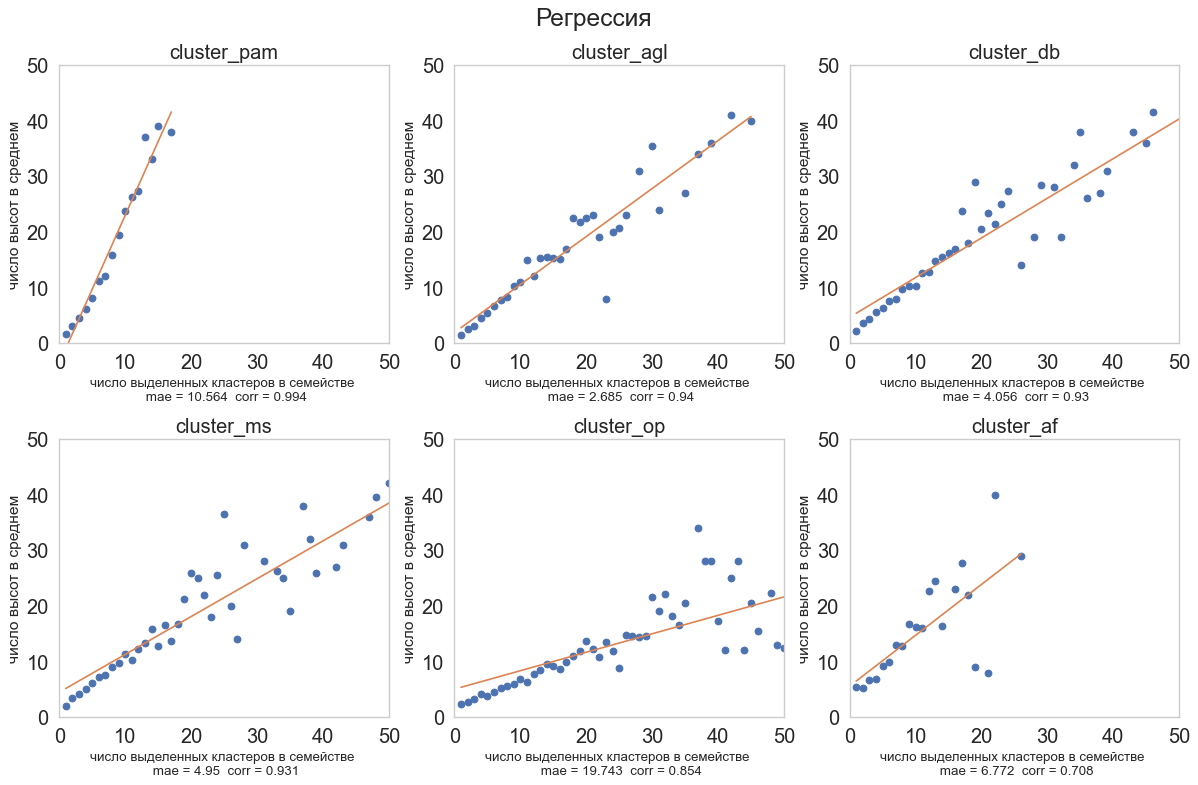

In [65]:
from sklearn.linear_model import LinearRegression

algorithm = ['cluster_pam', 'cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.suptitle('Регрессия')
plt.rcParams.update(params)

for i in range(6): 
    
    plotdf = return_number_h_cluster(clustered_df_old, ' num_of_family', algorithm[i])  
    plotdf = plotdf.groupby('number_clusters').agg({'number_h': ['mean', 'std']}).fillna(0).reset_index()
    
    number_clusters = plotdf['number_clusters']
    number_h = plotdf['number_h']['mean']
    
    reg = LinearRegression().fit(np.array(number_clusters).reshape(-1, 1), number_h)
    reg_v = reg.predict(np.array(number_clusters).reshape(-1, 1))

    m = round(mae(number_clusters, number_h), 3)
    corr = round(spearmanr(number_clusters, number_h)[0], 3)
    
    plt.subplot(2, 3, i+1)
    plt.title(algorithm[i])
    
    plt.plot(number_clusters, number_h,  'o')
    
    plt.plot(number_clusters, reg_v,  '-')
    
    plt.rcParams.update(params)
    plt.xlabel(f'число выделенных кластеров в семействе \n mae = {m}  corr = {corr}', size=12)
    plt.ylabel('число высот в среднем', size=14)
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    #plt.legend()
    plt.grid()
    
plt.tight_layout()

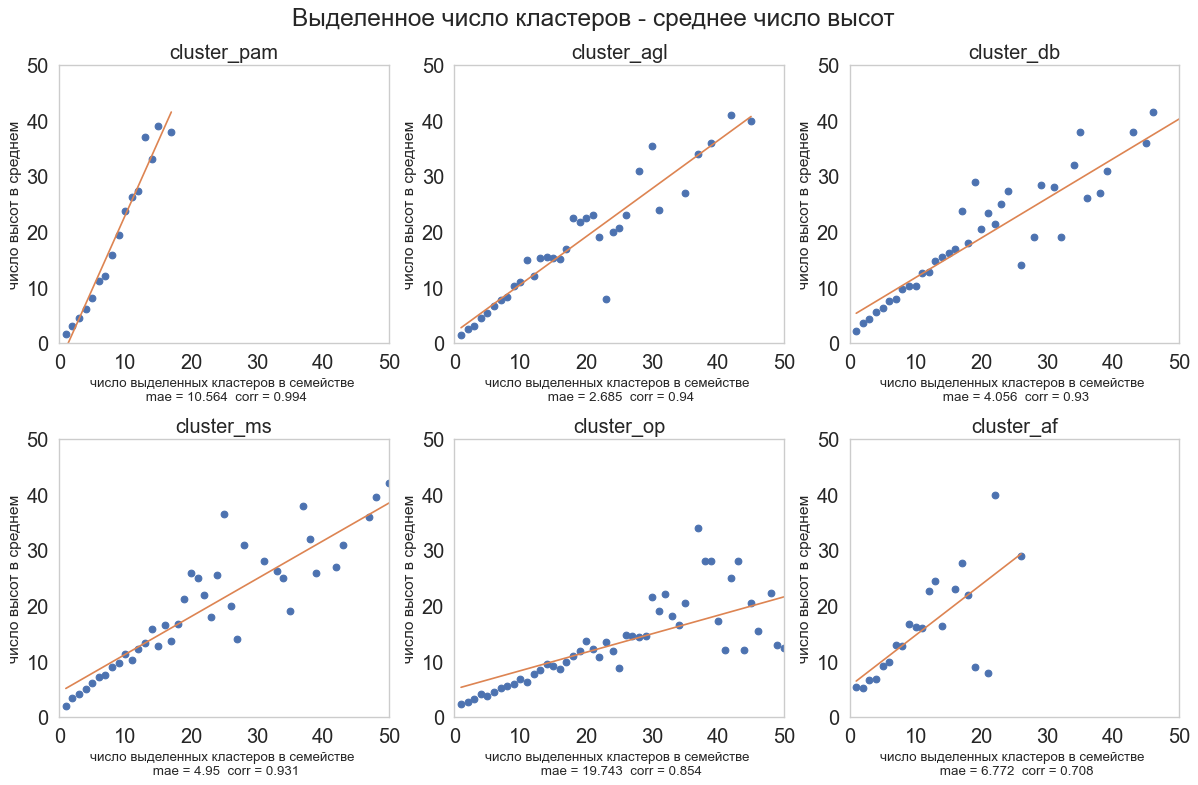

In [75]:
algorithm = ['cluster_pam', 'cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.suptitle('Выделенное число кластеров - среднее число высот')
plt.rcParams.update(params)

for i in range(6): 
    
    plotdf = return_number_h_cluster(clustered_df_old, ' num_of_family', algorithm[i])  
    plotdf = plotdf.groupby('number_clusters').agg({'number_h': ['mean', 'std']}).fillna(0).reset_index()
    
    number_clusters = plotdf['number_clusters']
    number_h = plotdf['number_h']['mean']
    
    mymodel = np.poly1d(np.polyfit(number_clusters, number_h, 1))

    m = round(mae(number_clusters, number_h), 3)
    corr = round(spearmanr(number_clusters, number_h)[0], 3)
    
    plt.subplot(2, 3, i+1)
    plt.title(algorithm[i])
    
    plt.plot(number_clusters, number_h,  'o')
    
    plt.plot(number_clusters, mymodel(number_clusters),  '-')
    
    plt.rcParams.update(params)
    plt.xlabel(f'число выделенных кластеров в семействе \n mae = {m}  corr = {corr}', size=12)
    plt.ylabel('число высот в среднем', size=14)
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    #plt.legend()
    plt.grid()
    
plt.tight_layout()
plt.savefig(f'images/clustering_h/regression.png')

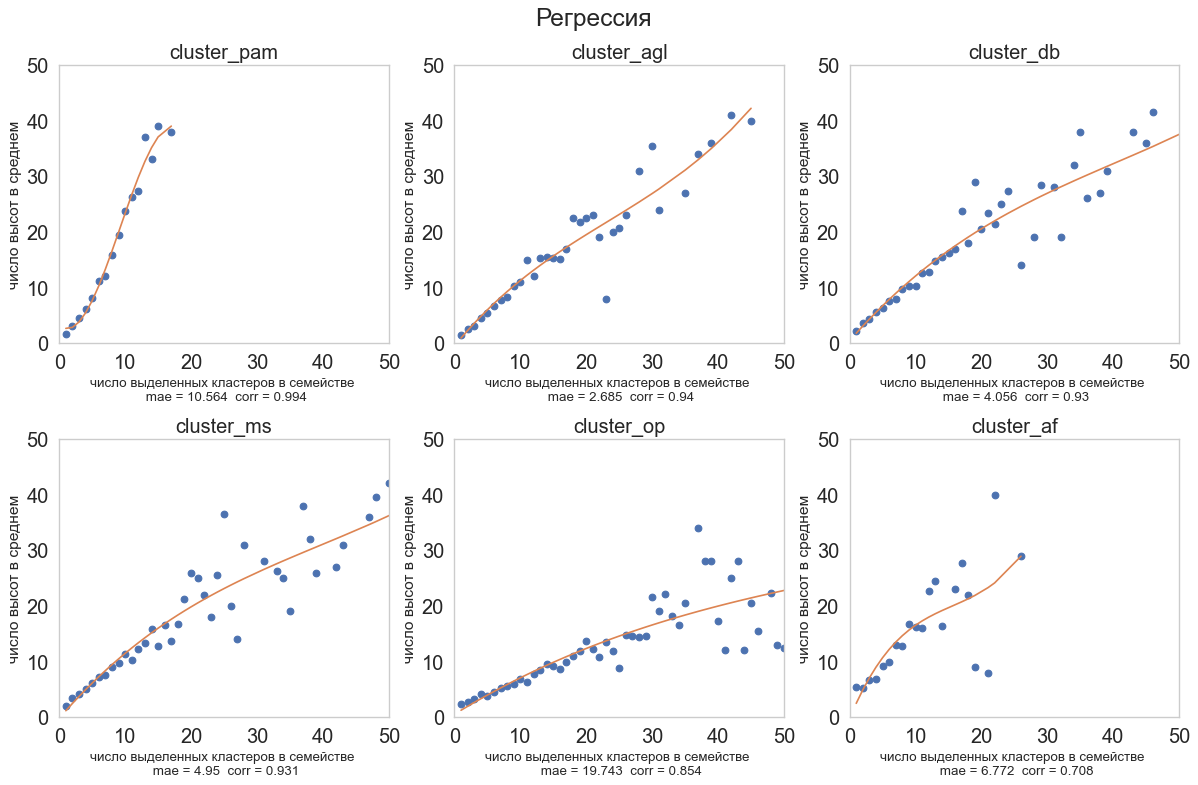

In [72]:
algorithm = ['cluster_pam', 'cluster_agl', 'cluster_db', 'cluster_ms', 'cluster_op', 'cluster_af']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.suptitle('Регрессия')
plt.rcParams.update(params)

for i in range(6): 
    
    plotdf = return_number_h_cluster(clustered_df_old, ' num_of_family', algorithm[i])  
    plotdf = plotdf.groupby('number_clusters').agg({'number_h': ['mean', 'std']}).fillna(0).reset_index()
    
    number_clusters = plotdf['number_clusters']
    number_h = plotdf['number_h']['mean']
    
    mymodel = np.poly1d(np.polyfit(number_clusters, number_h, 3))

    m = round(mae(number_clusters, number_h), 3)
    corr = round(spearmanr(number_clusters, number_h)[0], 3)
    
    plt.subplot(2, 3, i+1)
    plt.title(algorithm[i])
    
    plt.plot(number_clusters, number_h,  'o')
    
    plt.plot(number_clusters, mymodel(number_clusters),  '-')
    
    plt.rcParams.update(params)
    plt.xlabel(f'число выделенных кластеров в семействе \n mae = {m}  corr = {corr}', size=12)
    plt.ylabel('число высот в среднем', size=14)
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    #plt.legend()
    plt.grid()
    
plt.tight_layout()
#plt.savefig(f'images/clustering_h/polyregression.png')

### Посмотрим на кластеризацию экспериментального семейства
Есть ли эффект выстроенности.

In [14]:
# кластеризация экспериментальных данных
clustered_df_exp = pd.read_csv('clusterdata/clusteredDFexp', sep = '\t')
# кластеризация старой модели
clustered_df_old = pd.read_csv('clusterdata/clusteredDFold', sep = '\t')

In [64]:
df = clustered_df_exp[[' num_of_fam', 'X(J)', 'Y(J)', 'E(J)', 'cluster_agl', 'cluster_pam']].copy()

In [89]:
def one_cluster_visualisation(df, num_name=' num_of_fam', num=10, cluster_name='cluster_agl'):
    # Выбираем семмейство по номеру
    onefamily = df[df[num_name] == num].copy()
    
    
    # Выбираем 5 самых высоко энергичных кластера 
    onefamilyclust = onefamily.groupby(cluster_name)\
         .agg({'E(J)':'sum', 'X(J)':'mean', 'Y(J)':'mean', ' num_of_fam': 'mean'})\
         .reset_index()\
         .sort_values(by='E(J)', ascending = False).iloc[:4] 
    
    # Строим для них два графика
    fig = plt.figure(figsize=(10, 5), dpi=80)
    plt.subplot(1, 2, 1)
    plt.title('clustered_family')  
    plt.scatter(onefamily['X(J)'], onefamily['Y(J)'], c = onefamily[cluster_name])
    plt.xlabel('x ', size=14)
    plt.ylabel('y', size=14)
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    
    plt.subplot(1, 2, 2)
    plt.title('clusters')  
    plt.scatter(onefamilyclust['X(J)'], onefamilyclust['Y(J)'], c = onefamilyclust[cluster_name])  
    plt.rcParams.update(params)
    plt.xlabel('x ', size=14)
    plt.ylabel('y', size=14)
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    
    plt.suptitle(cluster_name)
    plt.show()

pamir 1


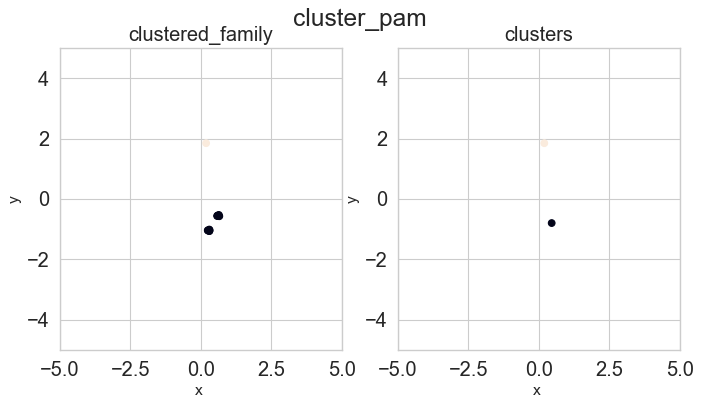

agglomerative 1


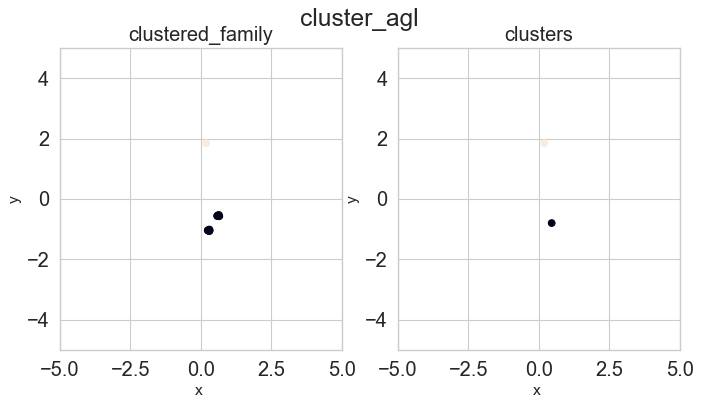

pamir 2


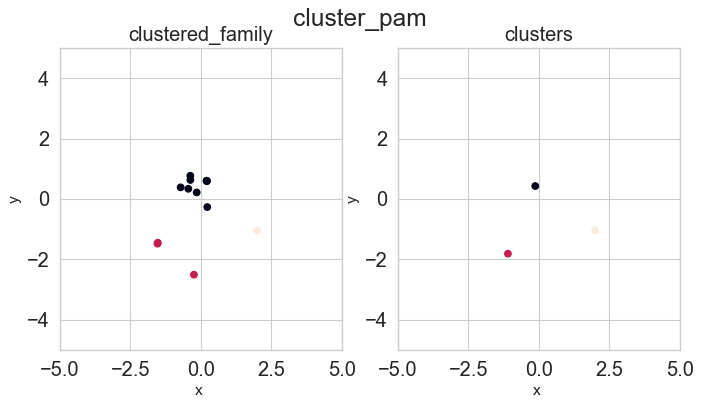

agglomerative 2


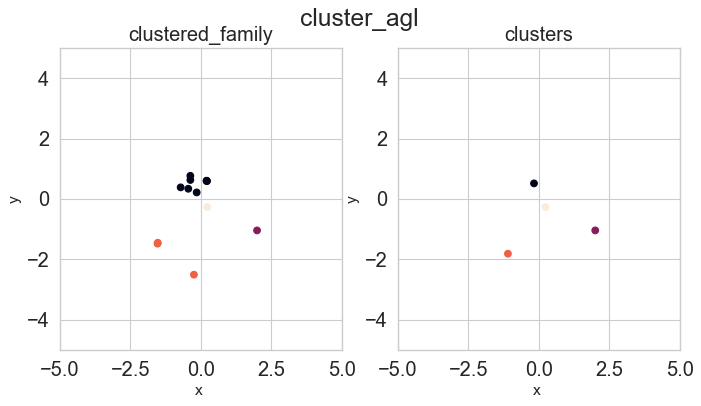

pamir 3


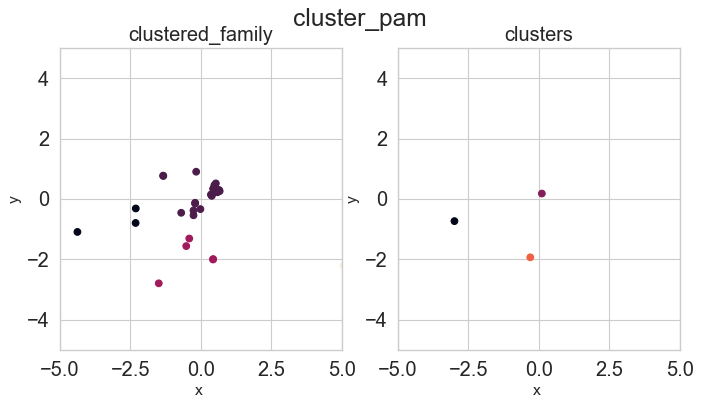

agglomerative 3


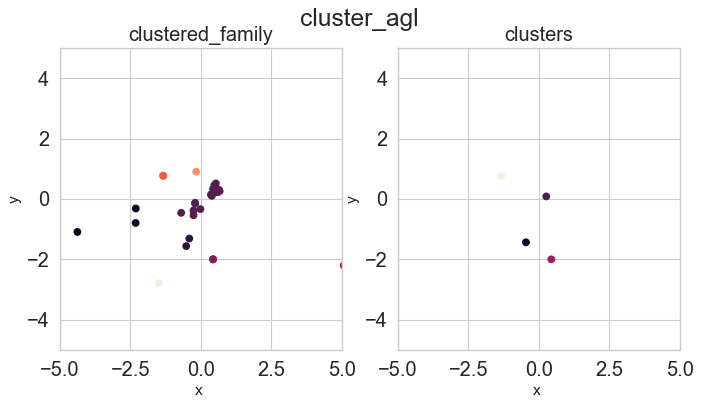

pamir 4


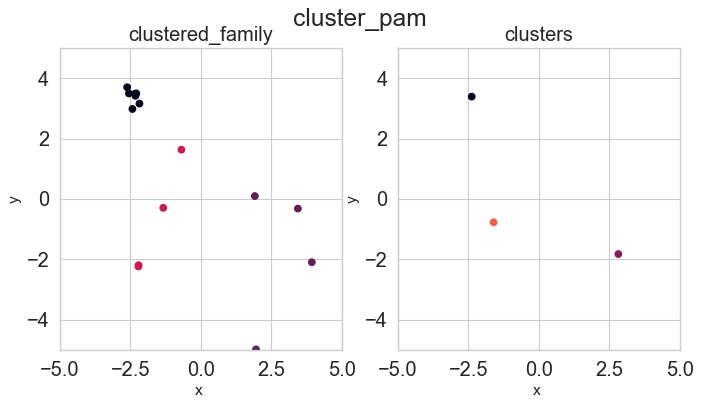

agglomerative 4


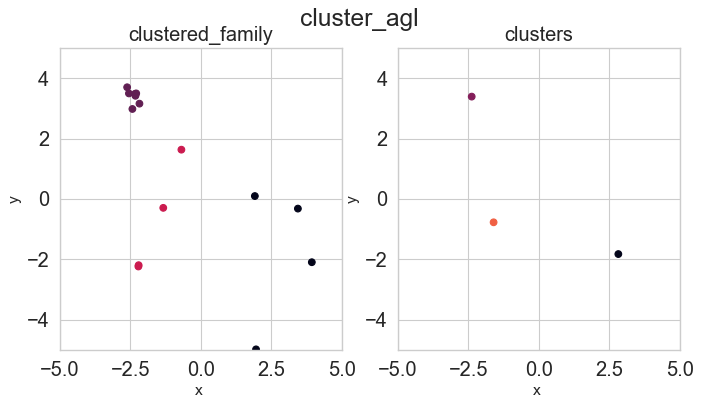

pamir 5


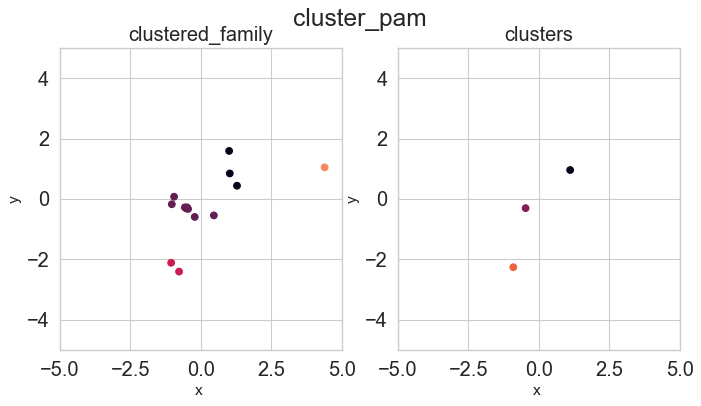

agglomerative 5


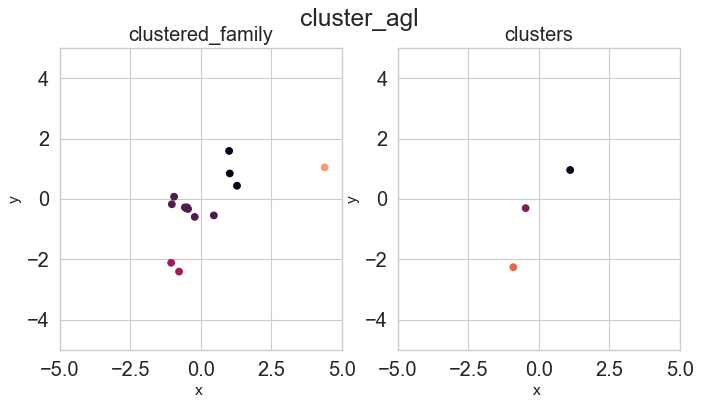

pamir 6


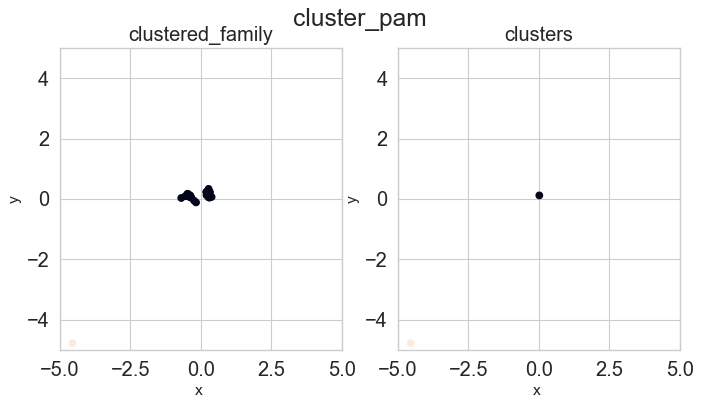

agglomerative 6


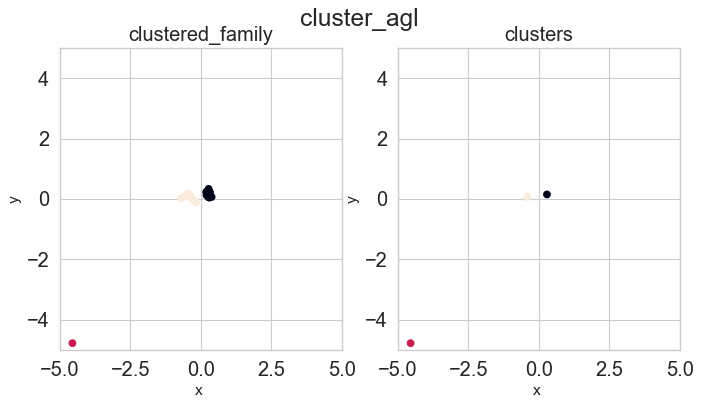

pamir 7


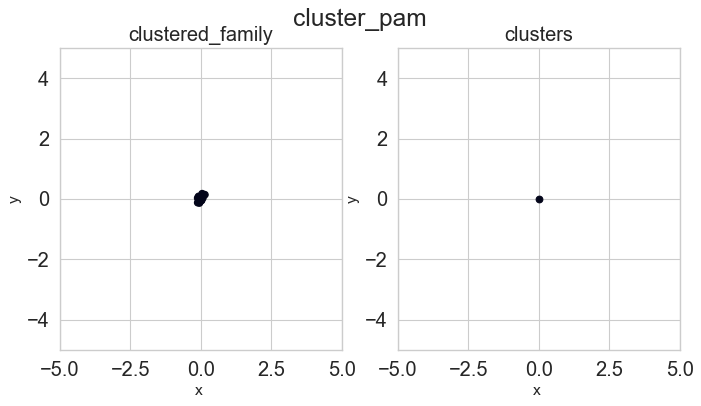

agglomerative 7


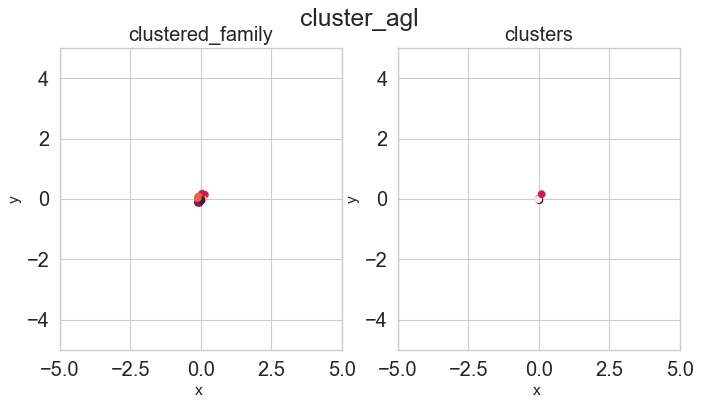

pamir 8


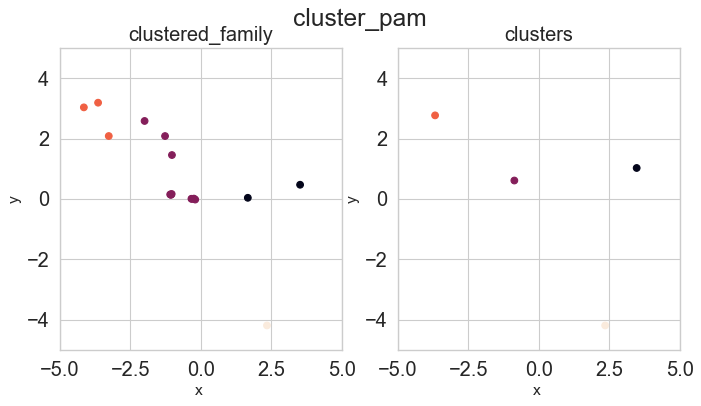

agglomerative 8


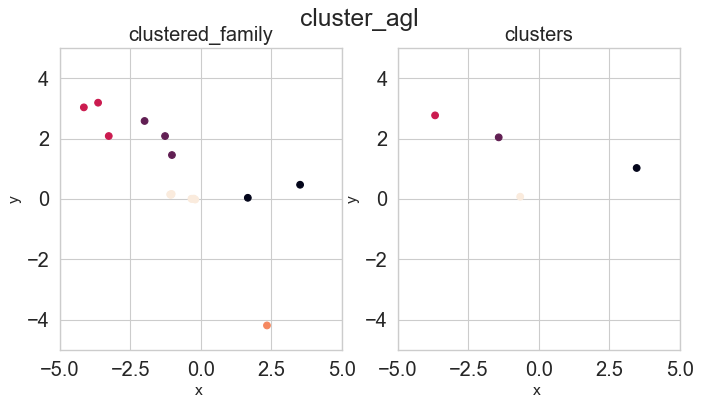

pamir 9


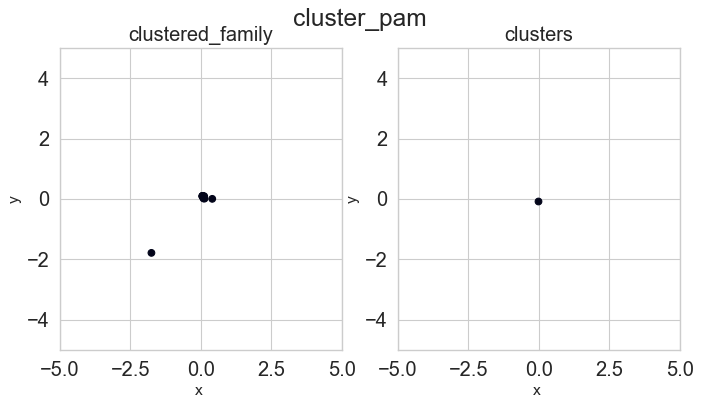

agglomerative 9


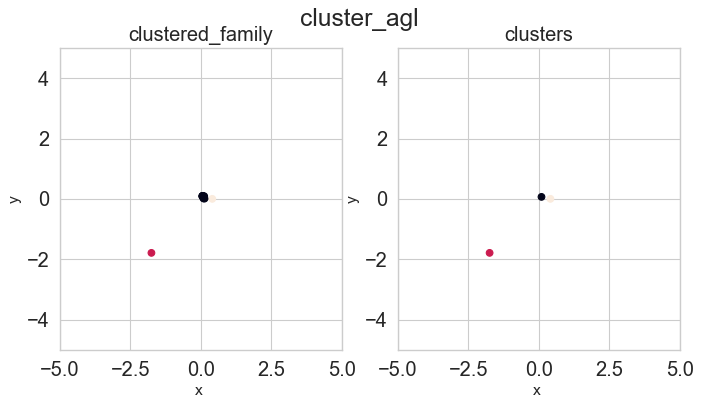

pamir 10


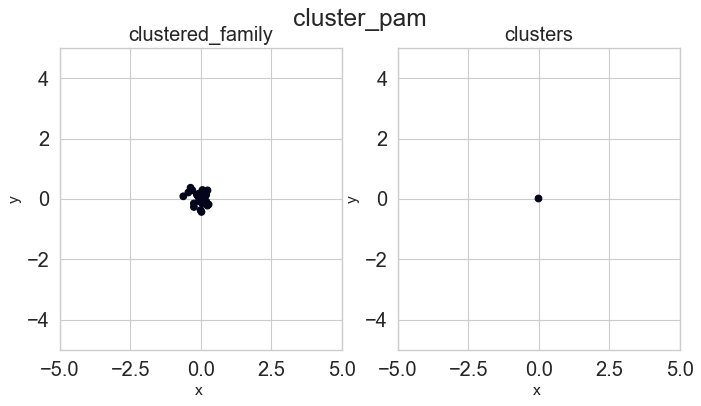

agglomerative 10


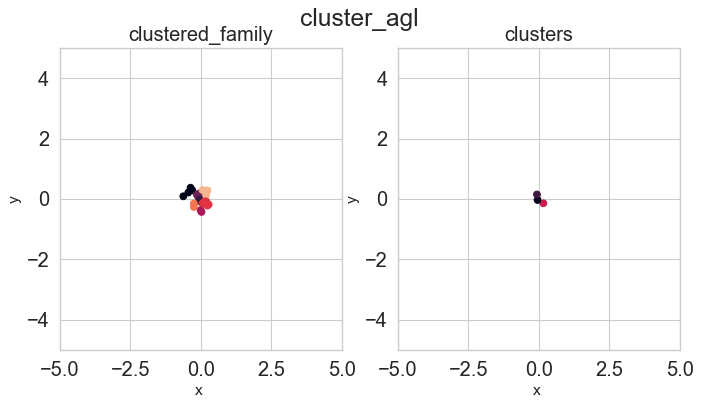

pamir 11


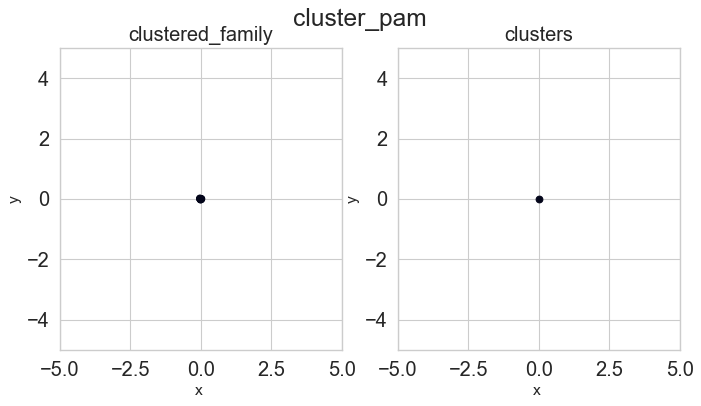

agglomerative 11


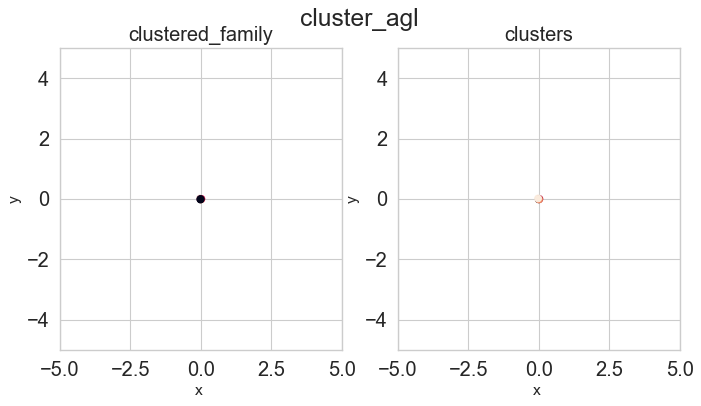

pamir 12


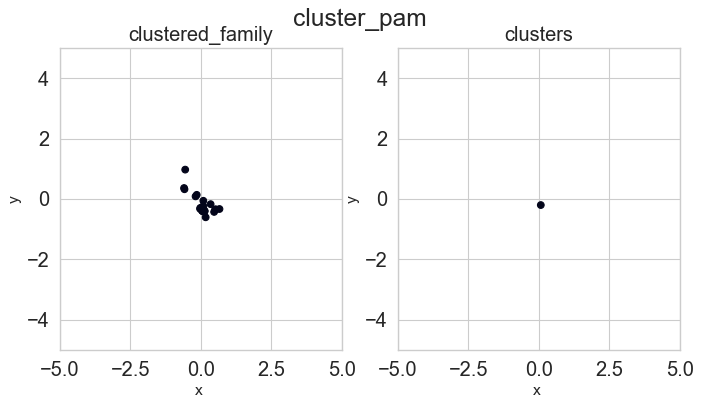

agglomerative 12


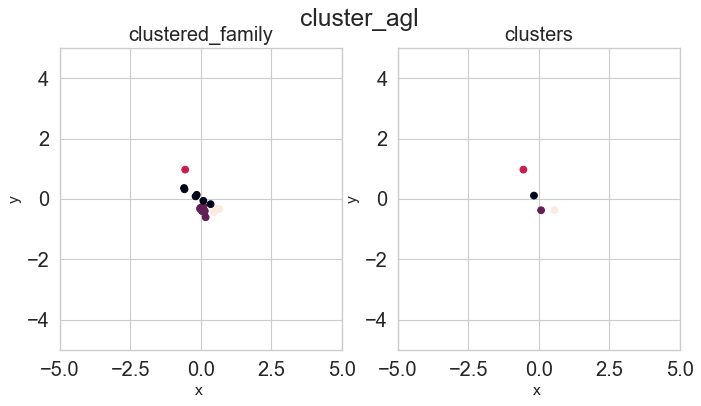

pamir 13


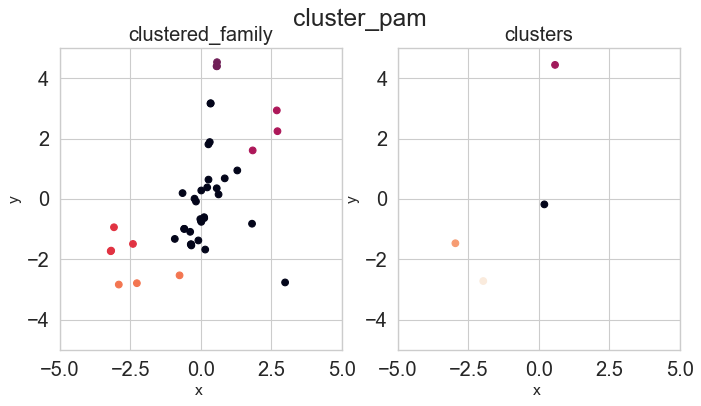

agglomerative 13


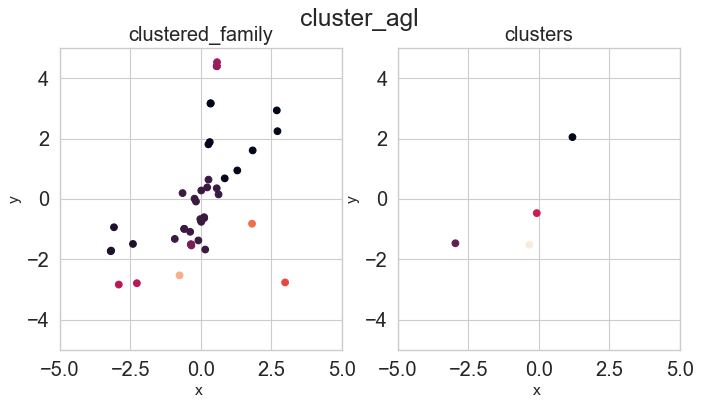

pamir 14


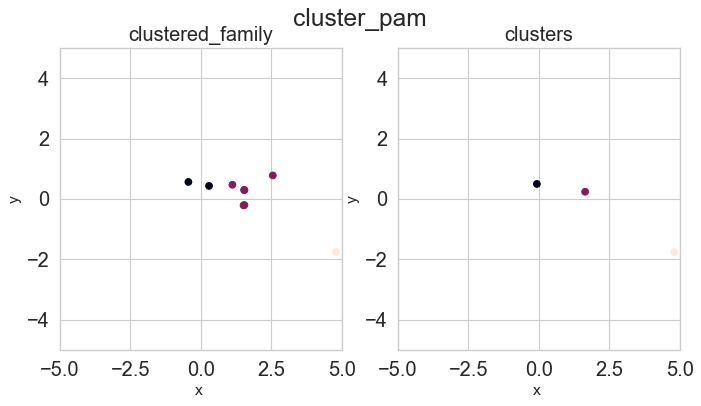

agglomerative 14


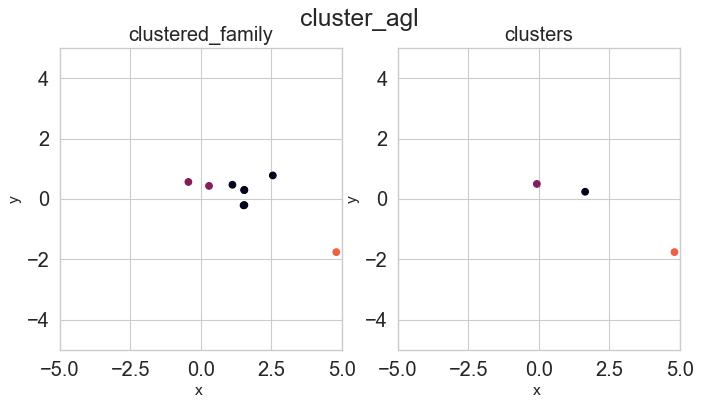

pamir 15


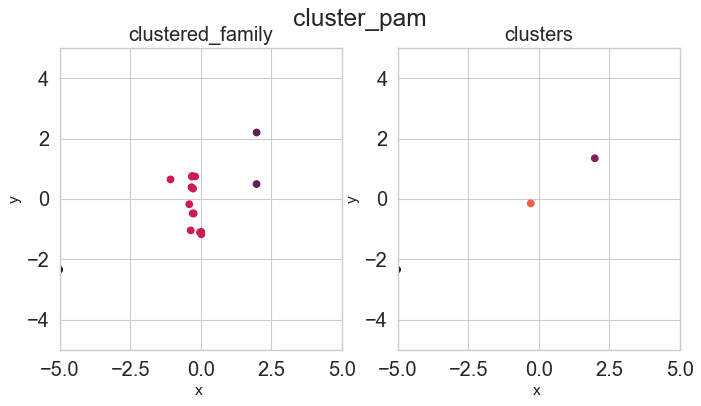

agglomerative 15


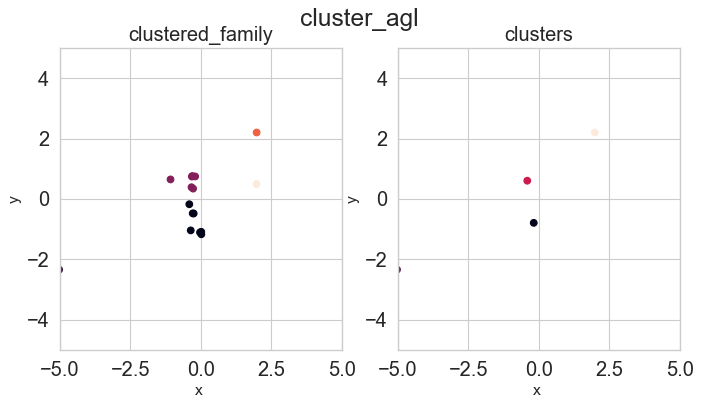

pamir 16


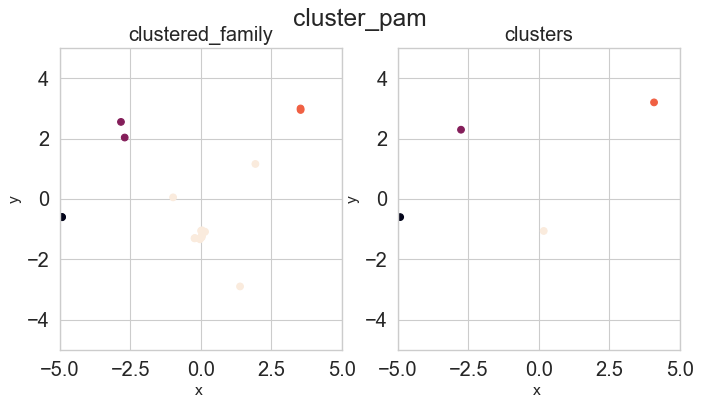

agglomerative 16


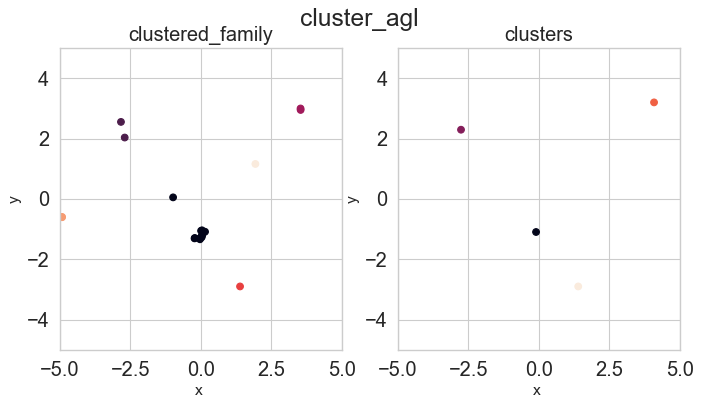

pamir 17


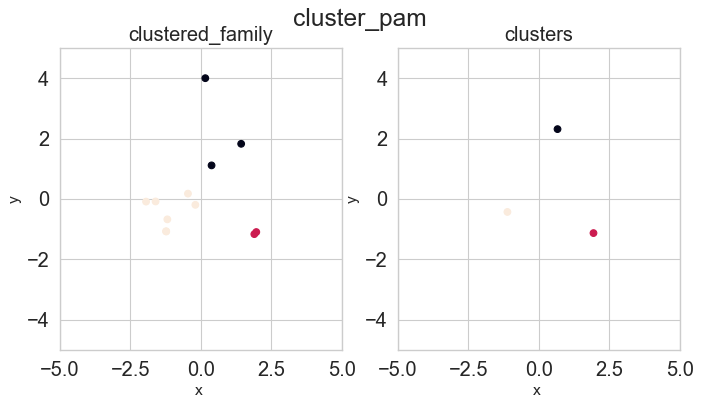

agglomerative 17


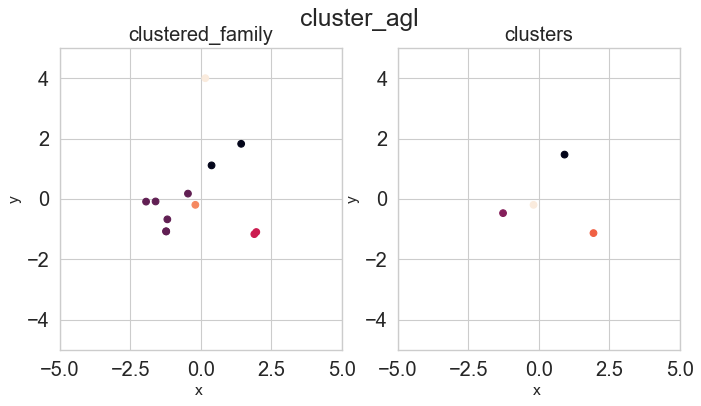

pamir 18


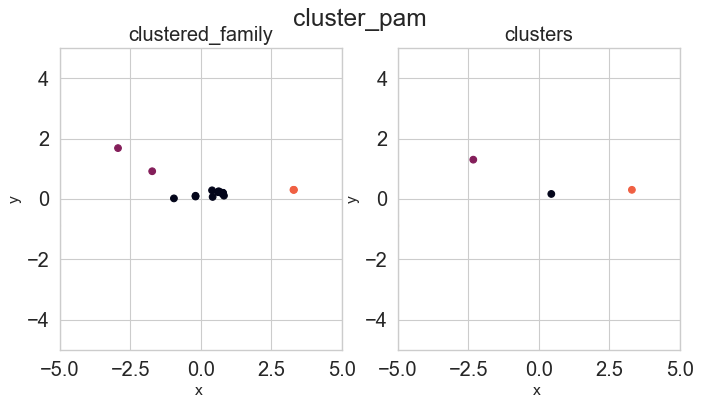

agglomerative 18


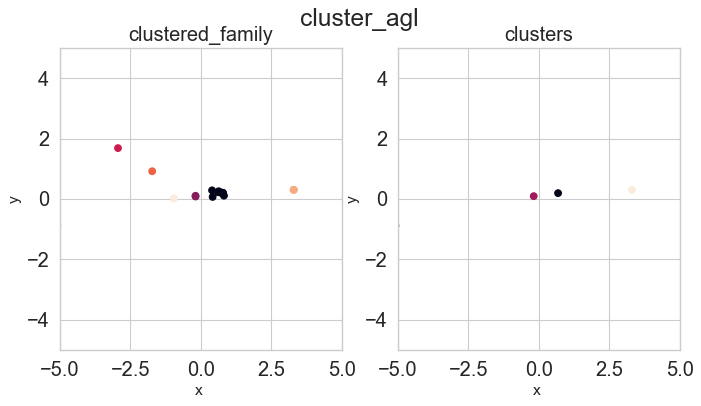

pamir 19


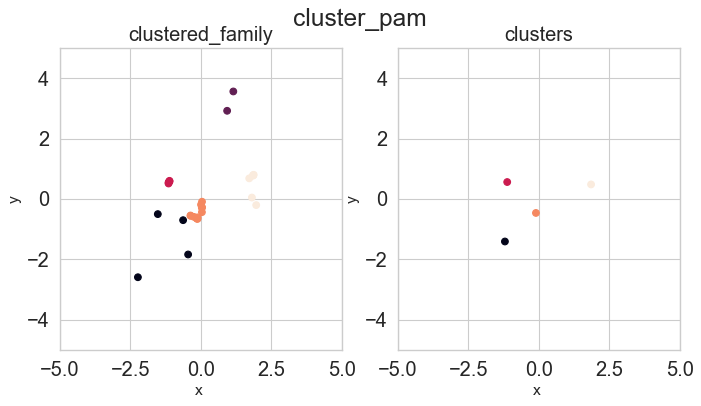

agglomerative 19


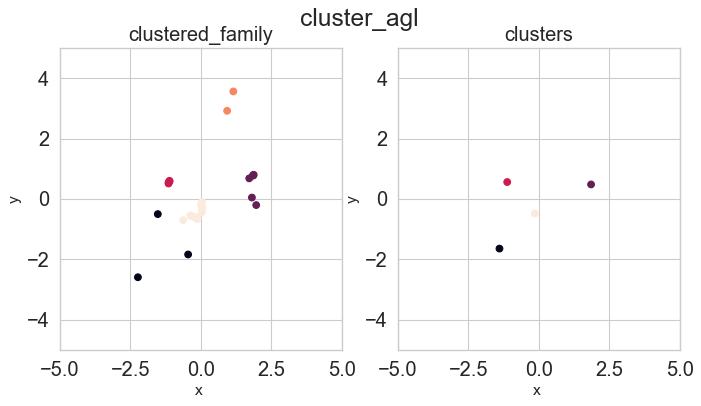

pamir 20


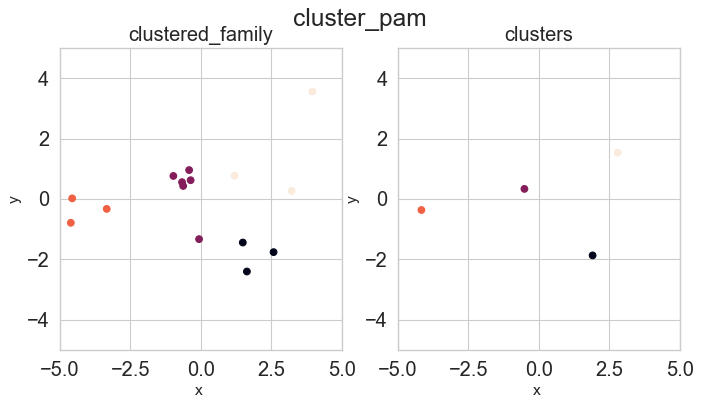

agglomerative 20


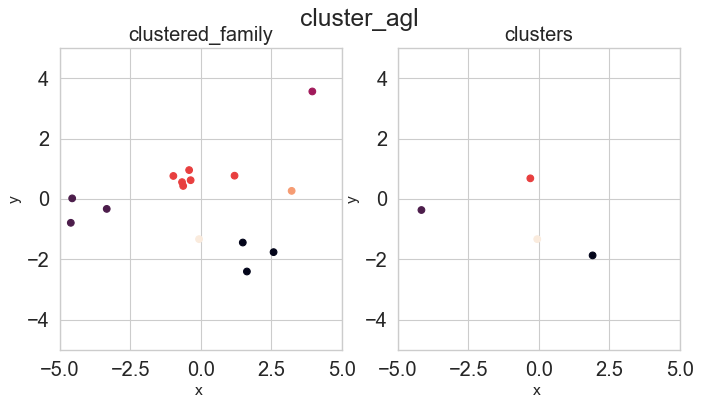

In [93]:
nums =list(set(df[' num_of_fam'].values))[:20]
for i in nums:
    print(f'pamir {i}')
    one_cluster_visualisation(df, ' num_of_fam', i, 'cluster_pam')
    print(f'agglomerative {i}')
    one_cluster_visualisation(df, ' num_of_fam', i, 'cluster_agl')